Projet Algèbre Linéaire pour la Data Science
================================================

Ce notebook à pour but d'expliquer la méthode de [SVD randomisée](https://research.fb.com/blog/2014/09/fast-randomized-svd/). <br>

Sommaire :
--------------------
1. Calcul d'une SVD classique et mesure de temps
2. Explication et implémentation de la version randomisée
3. Mesures pour la version randomisée en changeant les paramètres
   1. Calcul de performance
   2. Estimation de l'erreur
4. Calculs de statistiques sur l'erreur moyenne
   
   

# 1. Librairies python et récupération de l'image

Shape :  (355, 600)
Total size : 213000


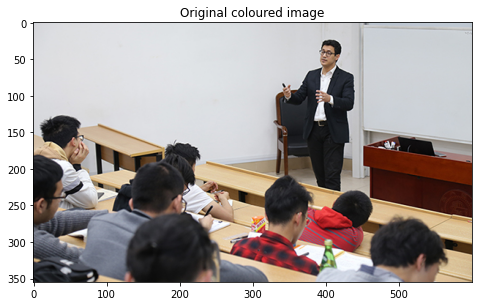

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from time import perf_counter
from utils import *
from profiler import fixed_rank_errors_random_matrixes, execute_t_times
from svd_func import *

np.set_printoptions(threshold=5)

img = getColouredImage('./resources/verysmall_600x355.jpg') #SVD : about a minute
# img = getColouredImage('./resources/big_12kx8k.jpg')
# img = getColouredImage('./resources/huge_12kx14k.jpg')

img = toGrayScale(img)
print("Shape : ",np.array(img).shape)
print("Total size :",np.array(img).shape[0]*np.array(img).shape[1])

# 2. SVD classique

In [4]:
A = np.array(img).transpose() #we transpose because the pic is horizontal
m, n = A.shape
size = m*n

print("Matrix shape :", A.shape)
print("Total number of elements :", size)

start = perf_counter()  
A_reconstructed = svd_regular(A)
end = perf_counter()

exact_error, rms_magnitude = compute_error(A, A_reconstructed)
print_result(exact_error, rms_magnitude, end-start, "Regular SVD")

Matrix shape : (600, 355)
Total number of elements : 213000

####################################################################
Regular SVD
>>> Duration : 0.16166 sec.
>>> Rooted mean squared Error (RMSE) : 10e-15
>>> Rooted sum squared Erros (RSSE)  : 1.423065228420128e-10
####################################################################


On constate que cette méthode est efficace car l'erreur $\lVert A - \tilde{A} \rVert$ est très faible (d'ordre `10e-16`). Cependant, elle est très longue à réaliser.
# 3. Méthodes de SVD randomisées
Dans cette partie nous allons projeter notre matrice $A$ dans un sous espace vectoriel plus petit afin de réaliser une SVD efficace sur ce sous espace restreint. <br>

## Algèbre linéaire randomisée
Nous allons dans un premier temps nous intéresser aux méthodes d'algèbre linéaire randomisées. <br>
Notamment la manière dont nous allons choisir notre "petit" sous espace dans lequel nous allons projeter $A$.
<br>
L'idée principale est donc de générer un sous-espace de $A$ qui approxime l'espace complet de $A$. <br>
Pour cela, nous allons choisir une matrice $\Omega$, générée de manière *aléatoire* et allons projeter A dans cet espace. <br>
La question naturelle qui se pose est : ***comment choisir efficacement notre $\Omega$ ?***

### Matrice à valeurs Gausiennes, Uniformes, ou "colonnes"
Nous allons observer le comportement de $\Omega$ en fonction de la méthode utilisée pour sa génération aléatoire.
Ensuite, nous étudierons ces différents $\Omega$ notamment à l'aide de SVD. <br>

Prenons 3 matrices : <br>
$$
\Omega_{1} \in \mathbb{R}^{m \times n} : \Omega_{i,j} \sim \mathcal{N}(0,1) \\ 
\ \\
\Omega_{2} \in \mathbb{R}^{m \times n} : \Omega_{i,j} \sim \mathcal{U}([0,1]) \\
\ \\
\Omega_{3} \in \mathbb{R}^{m \times n} : \forall i \in \llbracket0~;~n\rrbracket,~ \exists!~j \sim \mathcal{U}(\llbracket0,m\rrbracket) : \Omega_{i,j} = 1 \\
et\ \Omega_{i,k}=0 \ \ \forall~k \ne j
$$
- La première est une matrice à valeurs Gausiennes.<br>
- La seconde est une matrice à valeurs Uniformes.<br>
- La troisième est une matrice avec une unique valeur à 1 pour chaque colonne.<br>


Nous pouvons jouer sur la valeur de $m$ et observer comment convergent les valeurs singulières de ces matrices générées aléatoirement.

Sigma O1 :
 [[1.02 0.   0.   ... 0.   0.   0.  ]
 [0.   1.02 0.   ... 0.   0.   0.  ]
 [0.   0.   1.01 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.99 0.   0.  ]
 [0.   0.   0.   ... 0.   0.99 0.  ]
 [0.   0.   0.   ... 0.   0.   0.97]]


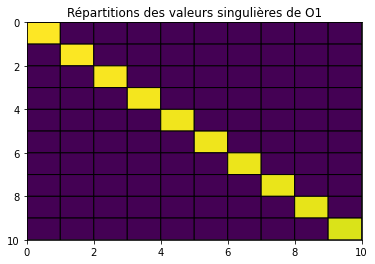

Sigma O2 :
 [[2.79 0.   0.   ... 0.   0.   0.  ]
 [0.   0.51 0.   ... 0.   0.   0.  ]
 [0.   0.   0.51 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.49 0.   0.  ]
 [0.   0.   0.   ... 0.   0.49 0.  ]
 [0.   0.   0.   ... 0.   0.   0.49]]


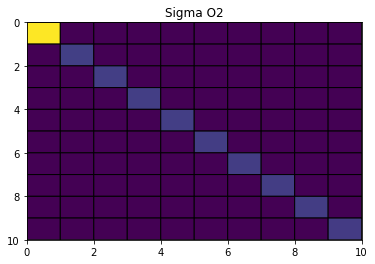

Sigma O3 :
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


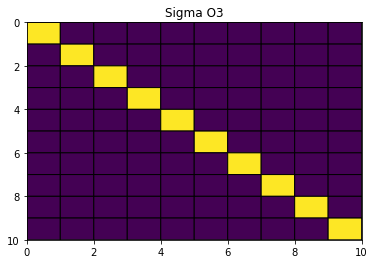

In [11]:
m = 10000
n = 10

Omega1=np.random.normal(0, 1, (m, n))

Omega2=np.random.uniform(0, 1, (m, n))

Omega3=np.zeros((m, n))
for c in Omega3.T :
    random_int = randint(0, m)
    c[random_int] = 1
    
U1, S1, Vt1 = np.linalg.svd(normalize(Omega1.T), full_matrices=False)
U2, S2, Vt2 = np.linalg.svd(normalize(Omega2.T), full_matrices=False)
U3, S3, Vt3 = np.linalg.svd(normalize(Omega3), full_matrices=False)

print("Sigma O1 :\n", np.diag(S1).round(2))
plt.figure(0)
plt.title("Répartitions des valeurs singulières de O1")
plt.gca().invert_yaxis()
plt.pcolor(np.diag(S1), edgecolors='k', linewidths=1)
plt.show()

print("Sigma O2 :\n", np.diag(S2).round(2))
plt.figure(1)
plt.title("Sigma O2")
plt.gca().invert_yaxis()
plt.pcolor(np.diag(S2), edgecolors='k', linewidths=1)
plt.show()

print("Sigma O3 :\n", np.diag(S3).round(2))
plt.figure(3)
plt.title("Sigma O3")
plt.gca().invert_yaxis()
plt.pcolor(np.diag(S3), edgecolors='k', linewidths=1)
plt.show()

Ces matrices $\Omega_{i}$ sont utilisées pour projeter A et obtenir un sous espace réduit sur lequel nous pourront réaliser des factorisations dans la suite du notebook (en commençant par une décomposition QR). <br>

## Application d'une SVD sur le sous espace aléatoire
Nous allons maintenant nous intéresser à la convergence de l'erreur $\lVert A - \tilde{A} \rVert$ en fonction des différents $\Omega_i$. <br>
Pour cette simulation, nous prenons $k = 50$, $k$ étant le nombre de colonnes que l'on garde pour la génération des matrices aléatoires dans le cas des SVD randomisées. Dans le cas de la SVD classique, 50 correspond au nombre de vecteurs et valeurs singuliers que nous gardons pour la reconstruction de $A$. <br>
Nous allons afficher ces valeurs pour les des matrices carrées dans $\mathbb{R}^{n \times n}$ avec $n$ prenant les différentes tailles du tableau `sizes`.

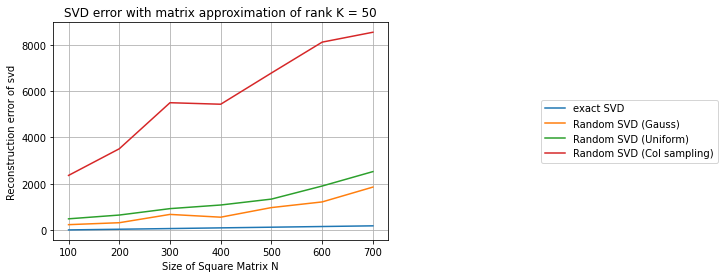

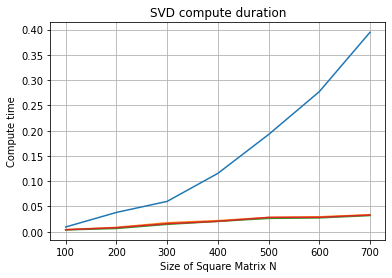

In [6]:
##########
# WARNING : this cell takes about 10 minutes to compute, you might just want to look at the graphs
##########

sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]
fixed_rank_errors_random_matrixes(sizes, k=50)

Nous allons continuer la suite du notebook en utilisant la RSVD basée sur une **matrice à valeurs gausiennes**.
On va exécuter $t$ fois la méthode sur la photo de départ en augmentant $t$ fois la valeur de $k$ jusqu'à atteindre `k_max`.

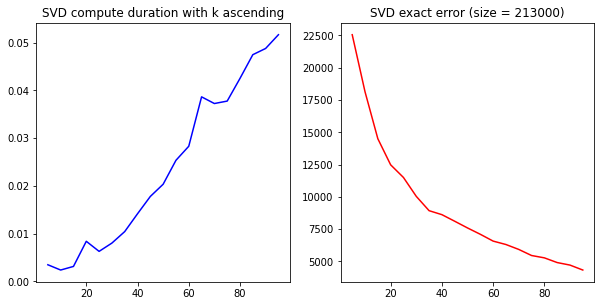

In [7]:
##########
# WARNING : long cell
##########


size = A.shape[0] * A.shape[1]
k_max = 100
t = 20

execute_t_times(20, svd_rand_gaussian, A, k_max, verbose=0)

### Résulatas d'éxécutions avec les autres méthodes randomisées (graphes précalculés) 

## Et au final... à l'oeil nu ?
Après tous ces tests et ces méthodes, voyons ce que cela donne à l'oeil nu sur l'image de départ. Bien sûr, cela n'est pas représentatif de tous les cas, pour du calcul scientifique par exemple, on peut réduire l'erreur générée par la RSVD au prix de la performance. Il faut donc juger en fonction du besoin quel type de matrice randomisée nous choisissons (*bien que la gaussienne semble être efficace dans la plupart des cas*), ainsi que la taille de notre troncature k.   

Total size is :  213000
	m =  600
	n =  355
Truncature size k is : 50, which is 14.085% of columns n


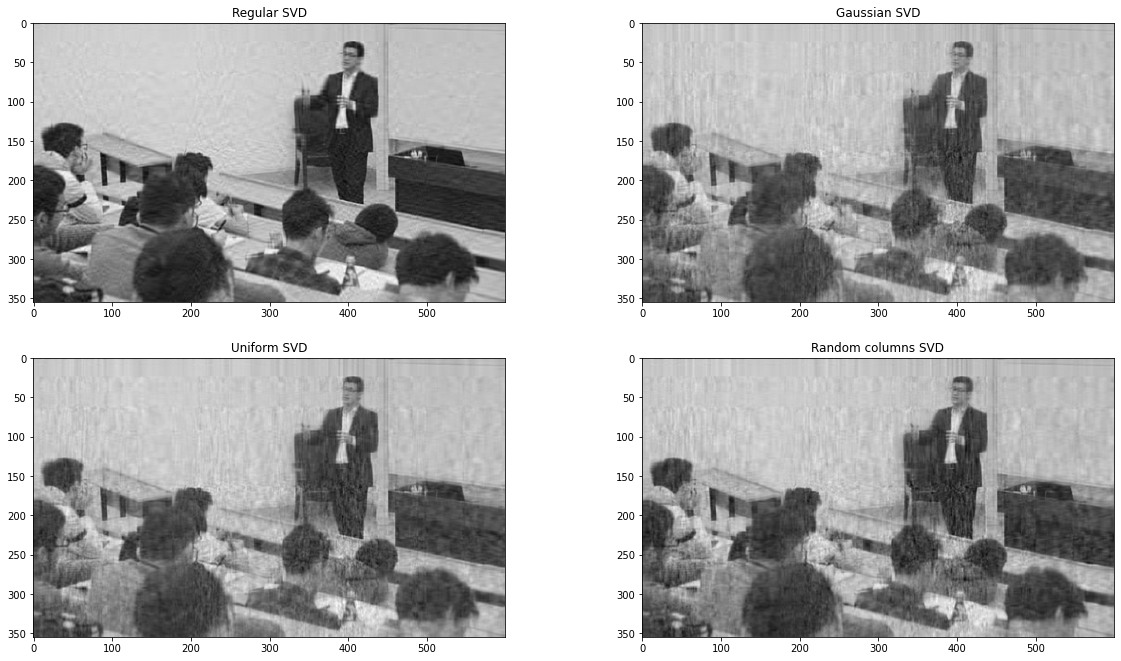

In [33]:
k = 50

m, n = A.shape
print("Total size is : ",m*n)
print("\tm = ", m)
print("\tn = ", n)

percentage = k/n*100
print("\rTruncature size k is : {}, which is {:.3f}% of columns n".format(k, percentage))


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20/1.77))
A_tilde = svd_regular(A, k)
axes[0][0].set_title("Regular SVD")
axes[0][0].imshow(A_tilde.T, cmap='gray')

A_tilde = svd_rand_gaussian(A, k)
axes[0][1].set_title("Gaussian SVD")
axes[0][1].imshow(A_tilde.T, cmap='gray')

A_tilde = svd_rand_uniform(A, k)
axes[1][0].set_title("Uniform SVD")
axes[1][0].imshow(A_tilde.T, cmap='gray')

A_tilde = svd_rand_columns(A, k)
axes[1][1].set_title("Random columns SVD")
axes[1][1].imshow(A_tilde.T, cmap='gray')

# 4. Etude statistique d'une méthode
Dans cette partie nous allons nous intéresser à l'erreur et le temps d'exécution moyens de la SVD randomisée en utilisant une matrice à valeurs Gausiennes. <br>
Voici comment nous allons procéder :
1. $N$ réalisations de la méthode RSVD, on garde les erreurs exactes (RSSE) et les durées d'exécution
2. Affichage des données récupérées sous forme d'histogramme
3. Ajustement à une loi de densité connue grâce à `fit` (*vu en cours de probas-stats*)
4. Estimation de l'espérance de l'erreur et du temps moyens     